In [1]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.9 MB/s eta 0:00:00


In [39]:
import pandas as pd
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [4]:
AWS_ACCESS_KEY_ID = ''
AWS_SECRET_ACCESS_KEY = ''
BUCKET_NAME = 'ix-iot-data-bucket'
FILE_PREFIX = 'HealthDataCSV/HealthData'

In [5]:
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)


In [6]:
# List all objects in the bucket with the specified prefix
objects = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=FILE_PREFIX)

# Initialize an empty list to store dataframes
dfs = []

# Iterate through the objects and read each file into a dataframe
for obj in objects.get('Contents', []):
    key = obj['Key']
    if not key.endswith('/'):  # Exclude directory prefixes
        try:
            file_obj = s3.get_object(Bucket=BUCKET_NAME, Key=key)
            df = pd.read_csv(file_obj['Body'])  # Adjust the read function if files are not csv
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {key}: {e}")

# Concatenate all dataframes into a single dataframe
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(df.head()) # Optional: display the first few rows
else:
    print("No files found in the specified bucket and path.")

         Type             StartDate               EndDate  Value Unit
0  Heart Rate  2024-12-03T19:41:06Z  2024-12-03T19:41:06Z  117.0  bpm
1  Heart Rate  2024-12-03T19:41:10Z  2024-12-03T19:41:10Z  116.0  bpm
2  Heart Rate  2024-12-03T19:41:12Z  2024-12-03T19:41:12Z  116.0  bpm
3  Heart Rate  2024-12-03T19:41:19Z  2024-12-03T19:41:19Z  115.0  bpm
4  Heart Rate  2024-12-03T19:41:22Z  2024-12-03T19:41:22Z  114.0  bpm


In [8]:
# Preprocessing
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['Duration'] = (df['EndDate'] - df['StartDate']).dt.total_seconds() / 60  # in minutes

In [17]:

# Filter data for StartDate after Dec 4th
df = df[df['StartDate'] >= '2024-12-04']
df['StartDate'].min()

Timestamp('2024-12-04 05:15:32+0000', tz='UTC')

In [18]:
# Separate data by type
heart_rate = df[df['Type'] == "Heart Rate"].copy()
sleep = df[df['Type'] == "Sleep"].copy()
blood_glucose = df[df['Type'] == "Blood Glucose"].copy()

In [19]:
sleep_state_map = {
    0: "In Bed",
    1: "Asleep Unspecified",
    2: "Awake",
    3: "Asleep",
    4: "Asleep Deep",
    5: "Asleep REM"
}

sleep['SleepState'] = sleep['Value'].map(sleep_state_map)

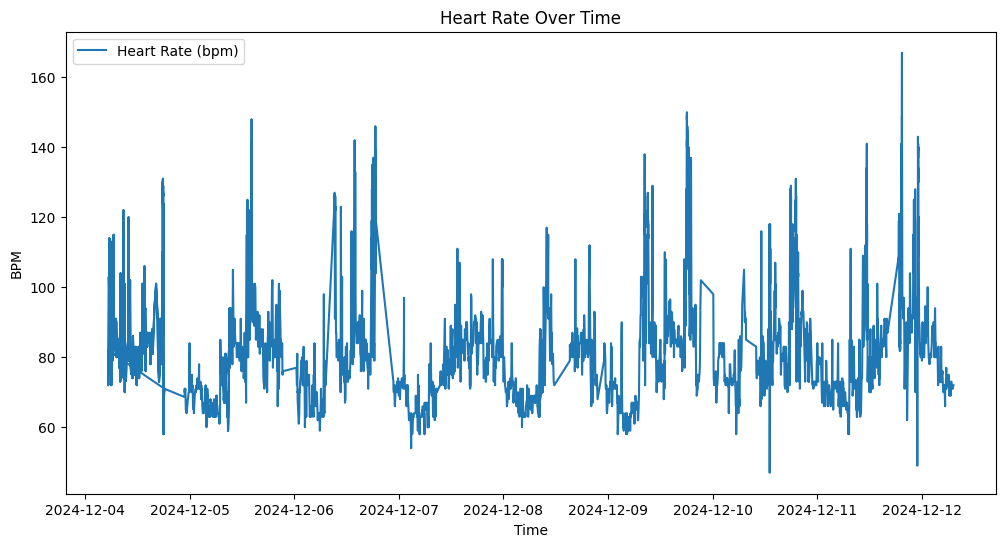

In [20]:
# Visualization: Time-series plot for each type
plt.figure(figsize=(12, 6))
plt.plot(heart_rate['StartDate'], heart_rate['Value'], label='Heart Rate (bpm)')
plt.title('Heart Rate Over Time')
plt.xlabel('Time')
plt.ylabel('BPM')
plt.legend()
plt.show()

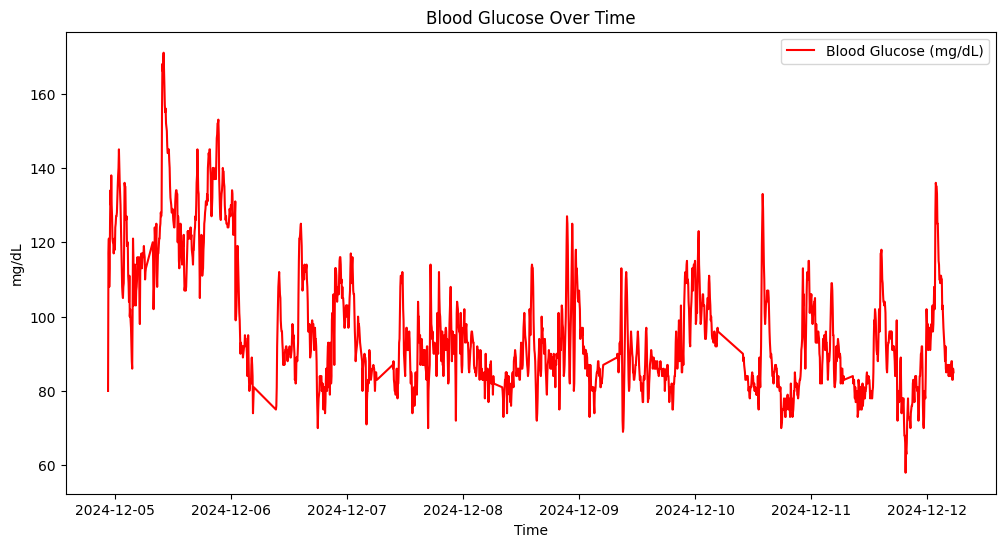

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(blood_glucose['StartDate'], blood_glucose['Value'], label='Blood Glucose (mg/dL)', color='red')
plt.title('Blood Glucose Over Time')
plt.xlabel('Time')
plt.ylabel('mg/dL')
plt.legend()
plt.show()

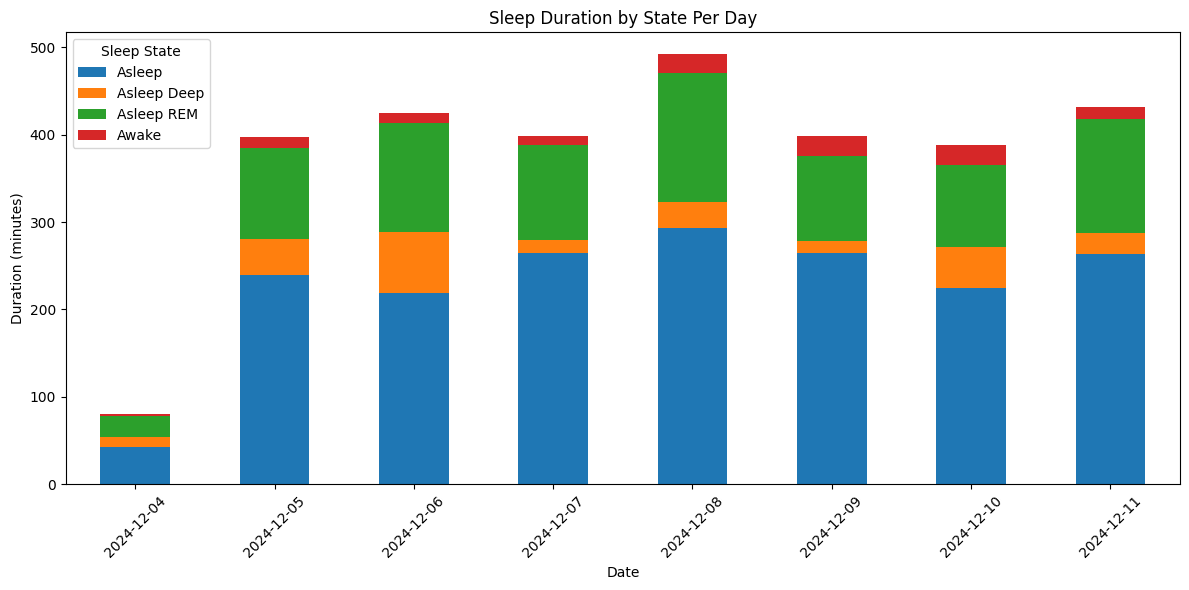

In [23]:


# Group by date and sleep state, then sum the durations
sleep_state_duration = sleep.groupby([sleep['StartDate'].dt.date, 'SleepState'])['Duration'].sum().unstack()

# Create the stacked bar plot
sleep_state_duration.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sleep Duration by State Per Day')
plt.xlabel('Date')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.legend(title='Sleep State')
plt.tight_layout()
plt.show()

In [24]:
# Statistical Analysis
print("Heart Rate Statistics")
print(heart_rate['Value'].describe())

print("\nBlood Glucose Statistics")
print(blood_glucose['Value'].describe())

print("\nSleep Statistics (Duration in Minutes)")
print(sleep['Duration'].describe())

Heart Rate Statistics
count    4781.000000
mean       97.430623
std        22.417076
min        47.000000
25%        79.000000
50%        95.000000
75%       117.000000
max       167.000000
Name: Value, dtype: float64

Blood Glucose Statistics
count    1858.000000
mean       96.583423
std        17.184538
min        58.000000
25%        84.000000
50%        92.000000
75%       106.000000
max       171.000000
Name: Value, dtype: float64

Sleep Statistics (Duration in Minutes)
count    211.000000
mean      14.274882
std       14.195750
min        0.500000
25%        2.000000
50%       10.000000
75%       23.250000
max       64.500000
Name: Duration, dtype: float64


In [26]:
# Load CGM data
cgm_data = blood_glucose.copy()


In [27]:
# Define target glucose range
TIR_LOWER = 70  # mg/dL
TIR_UPPER = 180  # mg/dL

# Time in Range (TIR)
total_readings = len(cgm_data)
in_range_readings = cgm_data[(cgm_data['Value'] >= TIR_LOWER) & (cgm_data['Value'] <= TIR_UPPER)]
tir_percentage = (len(in_range_readings) / total_readings) * 100


In [32]:
# Glucose Variability
mean_glucose = cgm_data['Value'].mean()
std_dev_glucose = cgm_data['Value'].std()
cv_glucose = (std_dev_glucose / mean_glucose) * 100  # Coefficient of Variation
mad_glucose = (cgm_data['Value'] - cgm_data['Value'].mean()).abs().mean()   # Mean Absolute Deviation
# Predicted HbA1c
predicted_hba1c = (mean_glucose + 46.7) / 28.7

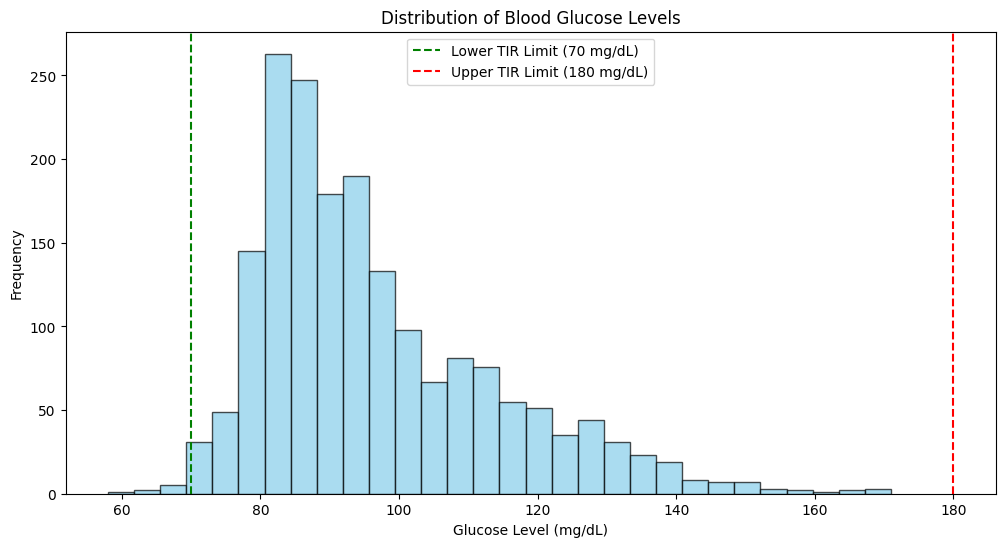

In [30]:
# Plot TIR
plt.figure(figsize=(12, 6))
plt.hist(cgm_data['Value'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(TIR_LOWER, color='green', linestyle='--', label='Lower TIR Limit (70 mg/dL)')
plt.axvline(TIR_UPPER, color='red', linestyle='--', label='Upper TIR Limit (180 mg/dL)')
plt.title('Distribution of Blood Glucose Levels')
plt.xlabel('Glucose Level (mg/dL)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [33]:
# Print the results
print("CGM Analysis Results:")
print(f"Time in Range (70-180 mg/dL): {tir_percentage:.2f}%")
print(f"Mean Glucose: {mean_glucose:.2f} mg/dL")
print(f"Standard Deviation of Glucose: {std_dev_glucose:.2f} mg/dL")
print(f"Coefficient of Variation (CV): {cv_glucose:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad_glucose:.2f} mg/dL")
print(f"Predicted HbA1c: {predicted_hba1c:.2f}%")

CGM Analysis Results:
Time in Range (70-180 mg/dL): 99.57%
Mean Glucose: 96.58 mg/dL
Standard Deviation of Glucose: 17.18 mg/dL
Coefficient of Variation (CV): 17.79%
Mean Absolute Deviation (MAD): 13.53 mg/dL
Predicted HbA1c: 4.99%


In [35]:
# Insights based on CGM metrics
if tir_percentage < 70:
    print("Warning: Time in Range (TIR) is below 70%, indicating poor glucose control.")

if cv_glucose > 36:
    print("Warning: High glucose variability detected (CV > 36%), increasing the risk of complications.")

if predicted_hba1c > 7:
    print("Predicted HbA1c is above the recommended threshold, suggesting suboptimal glucose control.")